In [31]:
import tensorflow as tf
import pandas as pd
import numpy as np
from os import getcwd, path
import os
import math

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib
import tensorflow as tf

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from textaugment import EDA
import nltk
import random
from random import shuffle
random.seed(1)

import matplotlib.pyplot as plt

from collections import defaultdict

from re import compile
import re

plt.style.use('ggplot')

# 1. Parameters

In [32]:
# Hyperparameters
text_cleaning = True
use_tfidf_tokenizer = True 
use_keras_tokenizer = True
use_pretrained_embeddings = True

# Initialize Model
epochs = 15
batch_size = 16

# Append "0" add the sentences ending to have equal sentences length
seq_input_len = 50
num_word = 10000

seed=123
np.random.seed(seed)

# 2. Functions

In [33]:
def plot_history(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
def create_embedding_matrix(filepath, word_index, embedding_dim):
    
    vocab_size_keras = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size_keras, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix


def cal_label_accuracy(conf_matrix, verbose = 0):
    
    label_acc = {}
    
    for index, x in enumerate(conf_matrix): 
        
        label_acc[index] = np.round( conf_matrix[index][index]/ sum(conf_matrix[index]) *100 , 2)
        
        if verbose > 0:
        
            print("Accuracy for label", index, ": ", label_acc[index] , " %" )
    
    return label_acc

    
def clean_text(text):
    """Function to clean raw corpus text.

    Parameters
    ----------
    text : obj: numpy.array: `str`
        Corpus text, each element being a sentence

    Returns
    -------
    text: obj: numpy.array : str
        Clean text
    """
    
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    
    
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    
    return text


def get_only_chars(line):

    clean_line = ""

    line = line.lower()
    line = line.replace(" 's", " is") 
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.replace("'", "")

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    #print(clean_line)
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

def text_augmentation_synonym(sentence, alpha_sr=0.1, num_aug=10):
    """
    Generate Synonyms sentences for a given sentence

    alpha: percentage of words to be synonymized in a sentence

    """

    sentence = get_only_chars(sentence)  # ["This is a house "]
    words = sentence.split(' ') # ["This",  "is", "a", "house", ""]
    words = [word for word in words if word is not '']
    num_words = len(words)

    augmented_sentences = []
    num_new_per_technique = int(num_aug/4)+1

    if (alpha_sr > 0):

        n_sr = max(1, int(alpha_sr*num_words))

        for random_state in range(num_aug):

            t = EDA(random_state = random_state)

            a_words = t.synonym_replacement(sentence, n_sr)

            a_words = ''.join(a_words)

            # only append if not already available
            if not a_words in augmented_sentences:

                augmented_sentences.append(a_words)


    return augmented_sentences

def create_corpus_augmented(corpus, alpha_sr, num_aug, verbose = 0 ):
    """
    This function takes every sentence in the corpus and generates
    synonym sentece give by the parameter num_aug. The number of words
    in each sentence to be synonymized is controlled by the parameter
    alpha_sr ( 0.0 - 1.0) where 1.0 means change all the words. 

    """
    corpus_augmented = []

    for index, row in corpus.iterrows():
        
        if verbose > 1:
            print("Generating synomyms for sentence :" , row['text'] )

        new_senteces = text_augmentation_synonym(sentence = row['text'],
                            alpha_sr = alpha_sr, 
                            num_aug = num_aug) 

        new_corpus_augmented = pd.DataFrame(dict( text = new_senteces ) )

        # Add Label
        new_corpus_augmented['label'] = row['label']  

        corpus_augmented.append(new_corpus_augmented)

    return pd.concat(corpus_augmented).reset_index(drop = True)


def create_class_weight(labels_dict,mu=0.5):

# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = mu*total/float(labels_dict[key])
        class_weight[key] = score if score > 1.0 else 1.0
    
    return class_weight



# 3. Data Ingest

## 3.1 Use Category Data

In [57]:
data_dir = 'data/ML_data_3.0.xlsx'
corpus = pd.read_excel(data_dir ,engine='openpyxl')

corpus = corpus[~corpus['label'].isna()][['text','label']]

 # Filter all NAs values
corpus.dropna(inplace= True)

 # Make Sure labels are integers
corpus['label'] = corpus['label'].astype(int)




## 3.2 Text Cleaning

In [58]:
if text_cleaning:

    corpus = corpus.reset_index(drop=True)

    REPLACE_BY_SPACE_RE = compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
  
    corpus['text'] = corpus['text'].apply(clean_text)
    corpus['text'] = corpus['text'].str.replace('\d+', '')


## 3.3 Text Augmentation

In [59]:
#Augment Corpus 
# augmented_corpus = create_corpus_augmented(corpus = corpus, alpha_sr = 0.1, num_aug = 2)

In [60]:
#Add new senteces to original corpus
# corpus = pd.concat([corpus, augmented_corpus]).reset_index(drop = True)

## 3.4 Class Weights

In [61]:
# labels_dict
labels_dict = {0: len(corpus[corpus['label']==0]), 1: len(corpus[corpus['label']==1]), 2: len(corpus[corpus['label']==2]), 3: len(corpus[corpus['label']==3]), 4: len(corpus[corpus['label']==4])}

create_class_weight(labels_dict)

{0: 1.0,
 1: 8.068181818181818,
 2: 7.553191489361702,
 3: 6.120689655172414,
 4: 5.756756756756757}

# 4. Prepare Trainig and Test data

In [62]:
# Get training X data
sentences = corpus['text'].values

# Use Label encoder for the expected output
Encoder = LabelEncoder()
encoded_Y = Encoder.fit_transform(corpus['label'].values)
Y = pd.get_dummies(encoded_Y).values

sentences_train, sentences_test, Y_train, Y_test = train_test_split( sentences, Y, test_size=0.25, stratify=corpus['label'])

output_label = len(np.unique(encoded_Y))


# 5. Word Tokenizer 

In [84]:
if use_keras_tokenizer:
    
    # Start Tokenizer Object
    tokenizer = Tokenizer(num_words=num_word,lower=None)

    # Train vocabulary
    tokenizer.fit_on_texts(sentences_train)

    X_train = tokenizer.texts_to_sequences(sentences_train) 
        
    X_test = tokenizer.texts_to_sequences(sentences_test)

    vocab_size_keras = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
   
    vocab_keras = tokenizer.word_index

    X_train_keras = pad_sequences(X_train, padding='post', maxlen=seq_input_len)
    X_test_keras = pad_sequences(X_test, padding='post', maxlen=seq_input_len)


if use_tfidf_tokenizer:
    
    # Create new Class TfidfVectorizer with max 5000 features
    Tfidf_vect = TfidfVectorizer(max_features=5000)

    # Learn vocabulary and idf from training set
    Tfidf_vect.fit(sentences_train)

    # Transfor both the train and the test to document-term matrix
    X_train_Tfidf = Tfidf_vect.transform(sentences_train).toarray()
    X_test_Tfidf = Tfidf_vect.transform(sentences_test).toarray()
 
    voca_Tfidf = Tfidf_vect.vocabulary_
    
    vocab_size_Tfidf = len(voca_Tfidf) + 1

    

# 6. Embeddings - Pre-trained Embedding Space ( GloVe )

In [85]:
if use_pretrained_embeddings: 
    
    embedding_dim = 300
    
    embedding_matrix = create_embedding_matrix(
     filepath = 'D:/Embeddings/GloVe/glove.6B.300d.txt',
     word_index = vocab_keras, 
     embedding_dim = embedding_dim)

# 7. Model - GRU 

## 7.1 GRU with Keras

In [90]:
del gru_model

In [91]:
emb_dim = embedding_matrix.shape[1]

gru_model = Sequential()


if use_pretrained_embeddings:  
  
    gru_model.add(layers.Embedding(vocab_size_keras, embedding_dim, 
                               weights = [embedding_matrix], 
                               input_length = seq_input_len, 
                               trainable = True))
else: 
    embedding_dim = 100 # Output Dimension - seq output length
    gru_model.add(layers.Embedding(vocab_size_keras, embedding_dim, input_length = seq_input_len))
    
gru_model.add(layers.turn_sequences=False))
gru_model.add(layers.DrGRU(32, reopout(0.5))
gru_model.add(layers.Dense(10, activation='softmax'))
gru_model.add(layers.Dense(output_label, activation = 'sigmoid'))
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 300)           1099800   
_________________________________________________________________
gru_8 (GRU)                  (None, 32)                32064     
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 55        
Total params: 1,132,249
Trainable params: 1,132,249
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
100/100 [==============================] - 5s 33ms/step - loss: 4.2446 - accuracy: 0.2576 - val_loss: 1.4841 - val_accuracy: 0.7036
Epoch 2/15
100/100 [==============================] - 3s 28ms/step - loss: 4.4114 - accuracy: 0.6924 - val_loss: 1.4693 - val_accuracy: 0.7036
Epoch 3/15
100/100 [==============================] - 3s 29ms/step - loss: 4.3052 - accuracy: 0.7040 - val_loss: 1.4627 - val_accuracy: 0.7036
Epoch 4/15
100/100 [==============================] - 3s 29ms/step - loss: 4.2652 - accuracy: 0.7124 - val_loss: 1.4558 - val_accuracy: 0.7036
Epoch 5/15
100/100 [==============================] - 3s 29ms/step - loss: 4.3912 - accuracy: 0.6933 - val_loss: 1.4605 - val_accuracy: 0.7036
Epoch 6/15
100/100 [==============================] - 3s 28ms/step - loss: 4.3726 - accuracy: 0.7009 - val_loss: 1.4389 - val_accuracy: 0.7036
Epoch 7/15
100/100 [==============================] - 3s 28ms/step - loss: 4.3108 - accuracy: 0.7048 - val_loss: 1.4632 - val_accuracy: 0.7036

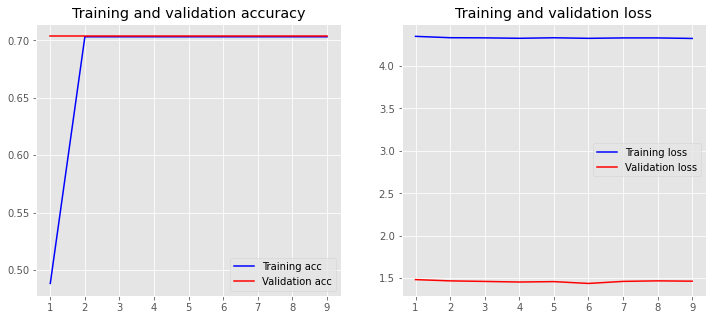

In [92]:
train_x = np.asarray(X_train_keras)
train_y = np.asarray(Y_train)
validation_x = np.asarray(X_test_keras)
validation_y = np.asarray(Y_test)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=True)


history = gru_model.fit(train_x, 
                    train_y, 
                    epochs = epochs, 
                    batch_size = batch_size,
                    validation_data = (validation_x, validation_y), 
                    class_weight = create_class_weight(labels_dict),
                    callbacks=callback)

loss, accuracy  = gru_model.evaluate(train_x, train_y, verbose=1, batch_size=256)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy  = gru_model.evaluate(validation_x, validation_y, verbose=1, batch_size=256)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Prediction

In [93]:
Y_pred = gru_model.predict(X_test_keras)

for pred in Y_pred:
    for index, value in enumerate(pred):
        if value == max(pred):
            pred[index] = int(1)
        else: 
            pred[index] = int(0)

## Metrics

In [94]:
print ('MSE:',loss)
print ('MAE:',accuracy)
print ('r2:',r2_score(validation_y, Y_pred))
conf_matrix = confusion_matrix(validation_y.argmax(axis=1), Y_pred.argmax(axis=1)) / len(Y_pred)
cal_label_accuracy(conf_matrix, verbose = 1)

MSE: 1.438949704170227
MAE: 0.7035647034645081
r2: -0.1484099720179238
Accuracy for label 0 :  100.0  %
Accuracy for label 1 :  0.0  %
Accuracy for label 2 :  0.0  %
Accuracy for label 3 :  0.0  %
Accuracy for label 4 :  0.0  %


{0: 100.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}

## 7.2 GRU with TFiDF


In [72]:
from sklearn.decomposition import PCA

# intialize pca and logistic regression model
TFIDF_matrix_dim = 50

pca = PCA(n_components = TFIDF_matrix_dim)

# fit and transform data
X_train_Tfidf = pca.fit_transform(X_train_Tfidf)
X_test_Tfidf = pca.transform(X_test_Tfidf)

# Transform to from 2D to 3D
X_train_Tfidf = np.expand_dims(X_train_Tfidf, axis=1)
X_test_Tfidf = np.expand_dims(X_test_Tfidf, axis=1)

text_len = TFIDF_matrix_dim

In [73]:
X_test_Tfidf.shape

(533, 1, 50)

In [74]:
text_len

50

In [75]:
emb_dim = embedding_matrix.shape[1]
del gru_model
gru_model = Sequential()


gru_model.add(layers.Input(shape=(1,text_len)))

# if use_pretrained_embeddings:  
  
#     gru_model.add(layers.Embedding(vocab_size_Tfidf, embedding_dim, 
#                                input_length = X_train_Tfidf.shape[1], 
#                                trainable = True))
# else: 
#     embedding_dim = 100 # Output Dimension - seq output length
#     gru_model.add(layers.Embedding(vocab_size, embedding_dim, input_length = X_train_Tfidf.shape[1]))
    
gru_model.add(layers.GRU(32, return_sequences=False))
gru_model.add(layers.Dropout(0.5))
gru_model.add(layers.Dense(10, activation='softmax'))
gru_model.add(layers.Dense(output_label, activation = 'sigmoid'))
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 32)                8064      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 55        
Total params: 8,449
Trainable params: 8,449
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
100/100 [==============================] - 0s 4ms/step - loss: 1.2561 - accuracy: 0.7195 - val_loss: 0.4175 - val_accuracy: 0.7186
Epoch 2/15
100/100 [==============================] - 0s 3ms/step - loss: 1.2326 - accuracy: 0.7301 - val_loss: 0.4059 - val_accuracy: 0.6998
Epoch 3/15
100/100 [==============================] - 0s 3ms/step - loss: 1.2114 - accuracy: 0.7207 - val_loss: 0.3988 - val_accuracy: 0.6923
Epoch 4/15
100/100 [==============================] - 0s 3ms/step - loss: 1.1915 - accuracy: 0.7245 - val_loss: 0.3857 - val_accuracy: 0.7036
Epoch 5/15
100/100 [==============================] - 0s 3ms/step - loss: 1.1747 - accuracy: 0.7138 - val_loss: 0.3774 - val_accuracy: 0.6979
Epoch 6/15
100/100 [==============================] - 0s 3ms/step - loss: 1.1541 - accuracy: 0.7182 - val_loss: 0.3759 - val_accuracy: 0.7017
Epoch 7/15
100/100 [==============================] - 0s 3ms/step - loss: 1.1404 - accuracy: 0.7170 - val_loss: 0.3655 - val_accuracy: 0.7017
Epoch 

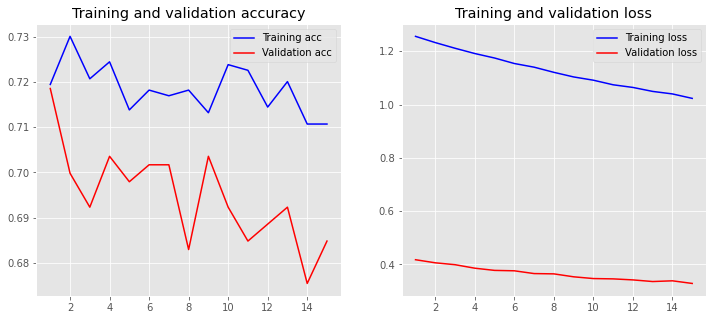

In [79]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=True)


history = gru_model.fit(X_train_Tfidf, Y_train,
                    epochs = epochs,
                    verbose = True,
                    validation_data = (X_test_Tfidf, Y_test),
                    batch_size = batch_size , 
                    class_weight = create_class_weight(labels_dict), 
                    callbacks = callback)

loss, accuracy = gru_model.evaluate(X_train_Tfidf, Y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = gru_model.evaluate(X_test_Tfidf, Y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Prediction

In [80]:
Y_pred = gru_model.predict(X_test_Tfidf)

for pred in Y_pred:
    for index, value in enumerate(pred):
        if value == max(pred):
            pred[index] = int(1)
        else: 
            pred[index] = int(0)

## Metrics

In [81]:
print ('MSE:',loss)
print ('MAE:',accuracy)
print ('r2:',r2_score(Y_test, Y_pred))
conf_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)) / len(Y_pred)
cal_label_accuracy(conf_matrix, verbose = 1)

MSE: 0.3284173309803009
MAE: 0.6848030090332031
r2: -0.43020358660879376
Accuracy for label 0 :  76.8  %
Accuracy for label 1 :  9.09  %
Accuracy for label 2 :  48.57  %
Accuracy for label 3 :  56.82  %
Accuracy for label 4 :  69.57  %


{0: 76.8, 1: 9.09, 2: 48.57, 3: 56.82, 4: 69.57}